<a href="https://colab.research.google.com/github/jitesh4144/AIES-LAB/blob/main/ex1_aies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baseline Selection Rates by Gender (0 = female, 1 = male):
Sex_male
False    0.786885
True     0.687500
Name: Selection Rate, dtype: float64
Baseline Accuracy: 1.0


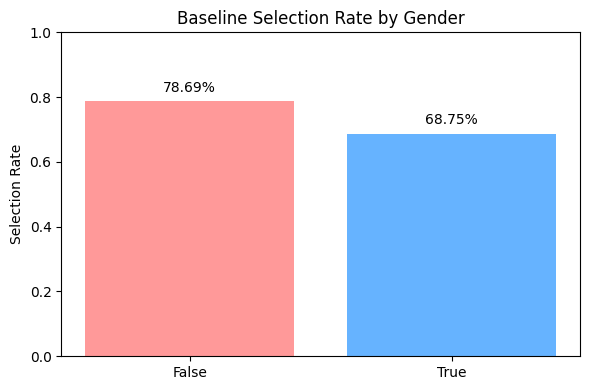


Fair Model Selection Rates by Gender (after fairness applied):
Sex_male
False    0.754098
True     0.687500
Name: Selection Rate, dtype: float64
Fair Model Accuracy: 0.9872611464968153


In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
import warnings
from sklearn.exceptions import ConvergenceWarning

# 🚫 Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 📥 Load dataset
data = pd.read_csv("/content/german_credit_data.csv")
data = data.drop(columns=["Unnamed: 0"], errors="ignore")  # drop ID column if present

# 🎯 Create binary target: good credit if Duration <= 24 months
data["target"] = np.where(data["Duration"] <= 24, 1, 0)

# 🧼 Drop missing values
data = data.dropna()

# 🔁 One-hot encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# 📊 Features and label
X = data.drop(columns=["target"])
y = data["target"]

# 🔍 Sensitive attribute: gender
sensitive_feature = X["Sex_male"]  # created from get_dummies

# 🧪 Train-test split
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)

# ⚙️ Baseline model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 📏 Baseline fairness evaluation
metric_frame = MetricFrame(
    metrics={"Selection Rate": selection_rate, "Accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sf_test
)

# ✅ Minimal output
print("Baseline Selection Rates by Gender (0 = female, 1 = male):")
print(metric_frame.by_group["Selection Rate"])
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))

# 📊 Plot selection rate (baseline)
sr = metric_frame.by_group["Selection Rate"].to_dict()
df_vis = pd.DataFrame(list(sr.items()), columns=["Gender (Sex_male)", "Selection Rate"])
plt.figure(figsize=(6, 4))
bars = plt.bar(df_vis["Gender (Sex_male)"].astype(str), df_vis["Selection Rate"], color=["#ff9999", "#66b3ff"])
plt.title("Baseline Selection Rate by Gender")
plt.ylabel("Selection Rate")
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# ⚖️ Fair model with Demographic Parity constraint
fair_model = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=2000),
    constraints=DemographicParity(),
    eps=0.01
)
fair_model.fit(X_train, y_train, sensitive_features=sf_train)
y_pred_fair = fair_model.predict(X_test)

# 📏 Fair model evaluation
fair_metric_frame = MetricFrame(
    metrics={"Selection Rate": selection_rate, "Accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sf_test
)

# ✅ Minimal fair model output
print("\nFair Model Selection Rates by Gender (after fairness applied):")
print(fair_metric_frame.by_group["Selection Rate"])
print("Fair Model Accuracy:", accuracy_score(y_test, y_pred_fair))
